In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox

%matplotlib inline

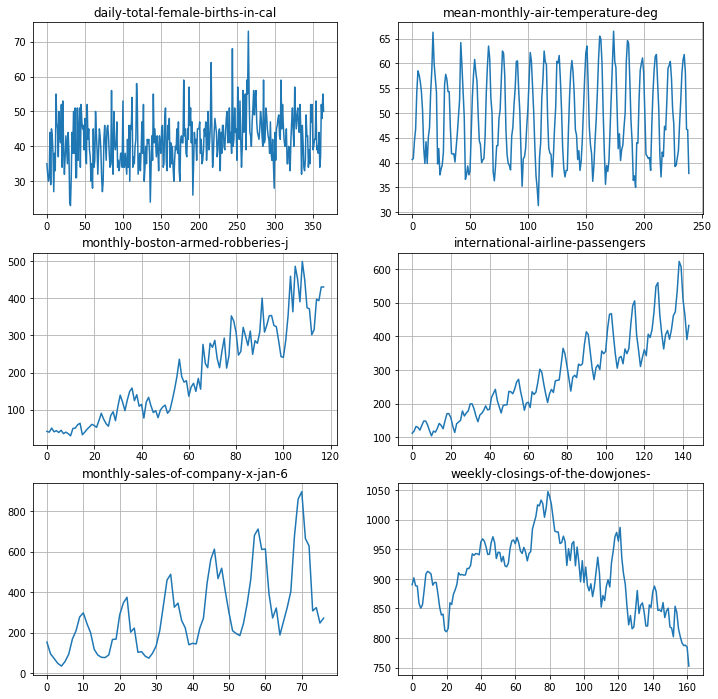

In [2]:
import os
fig = plt.figure()
fig.set_size_inches(12,12)

for n, fl in enumerate(os.listdir('TimeSeries/Series')):    
    ax = fig.add_subplot(3,2,n+1)
    ax.grid()
    ax.plot(pd.read_csv('TimeSeries/Series/'+fl).iloc[:,1])
    ax.set_title(fl[:-4])

**Для изучения выбран график вооруженных ограблений в Бостоне**

In [3]:
#ts = pd.read_csv('TimeSeries/Series/weekly-closings-of-the-dowjones-.csv')
#ts = pd.read_csv('TimeSeries/Series/international-airline-passengers.csv')
ts = pd.read_csv('TimeSeries/Series/monthly-boston-armed-robberies-j.csv')

**Ряд, очевидно, нестационарный, имеет тренд, а так же мультиплиткативную составляющую, из-за которой растет амплитуда со временем.**

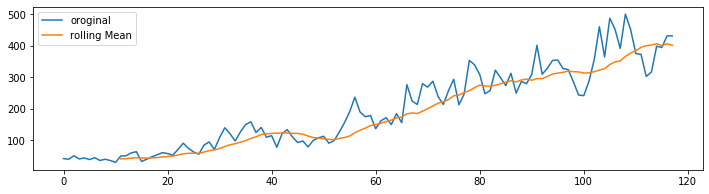

In [4]:
plt.rcParams['figure.figsize'] = (12,3)

plt.plot(ts.iloc[:,1], label='oroginal')
plt.plot(ts.iloc[:,1].rolling(12).mean(), label='rolling Mean')
plt.legend()

In [5]:
# Вспомогательная функция
def adf(ts):
    plt.figure(figsize=(12,4))
    plt.grid()
    plt.plot(ts);
    plot_acf(ts);
    plot_pacf(ts);
    result = adfuller(ts)
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

**Убираем мультипликативную составляющую и разделяем ряд на обучающую и тестовую выборки.**

In [6]:
ts_log=pd.Series(boxcox(ts.iloc[:,1])[0])

In [7]:
train = ts_log[:int(len(ts_log)*0.75)]
test = ts_log[int(len(ts_log)*0.75)+1:]

**Обучение на гиперпараметрах, подобранных вручную при помощи ARIMA:**

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                   86
Model:                 ARIMA(2, 2, 1)   Log Likelihood                -118.963
Method:                       css-mle   S.D. of innovations              0.935
Date:                Sat, 14 Mar 2020   AIC                            247.925
Time:                        19:19:56   BIC                            260.197
Sample:                             2   HQIC                           252.864
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -7.064e-05      0.003     -0.027      0.979      -0.005       0.005
ar.L1.D2.y    -0.2774      0.105     -2.647      0.008      -0.483      -0.072
ar.L2.D2.y    -0.2625      0.104     -2.513      0.0

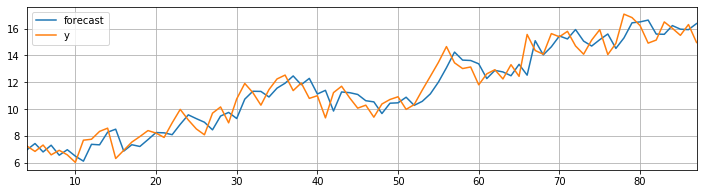

In [8]:
model = smt.ARIMA(train, order=(2,2,1))
results = model.fit(disp=0)
print(results.summary())
results.plot_predict(dynamic=False)
plt.grid()

**Ошибка имеет нормальное распределение, то есть, она является белым шумом. Можно сделать вывод, что модель использовала всю полезную информацию из предоставленных данных**

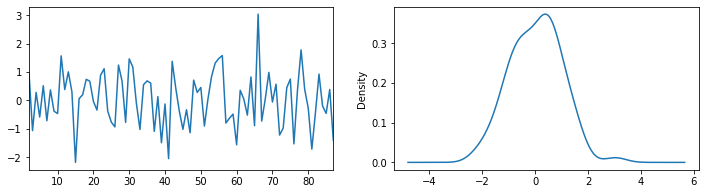

In [9]:
fig, ax = plt.subplots(1,2)
results.resid.plot(ax=ax[0])
results.resid.plot(kind='kde',ax=ax[1])


ADF Statistic: -9.623204229599123
p-value: 1.6873622680439445e-16
Critical Values:
	1%: -3.5097356063504983
	5%: -2.8961947486260944
	10%: -2.5852576124567475


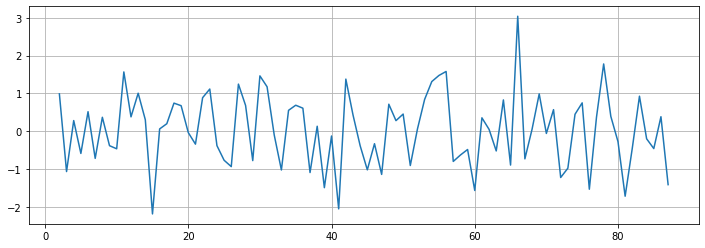

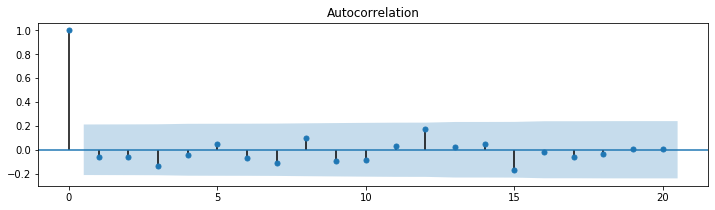

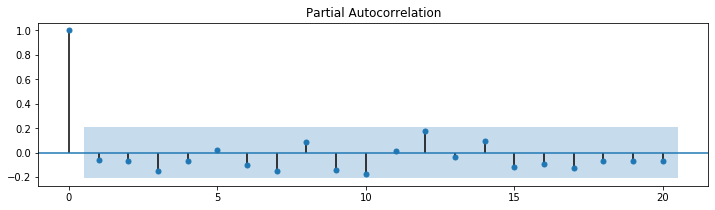

In [10]:
adf(results.resid)

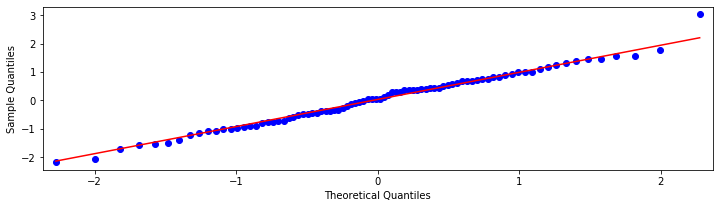

In [11]:
sm.qqplot(results.resid, line='s');

**На тестовой выборке модель показала точность 94.66% (с 1й производной точность была 93.5%)**

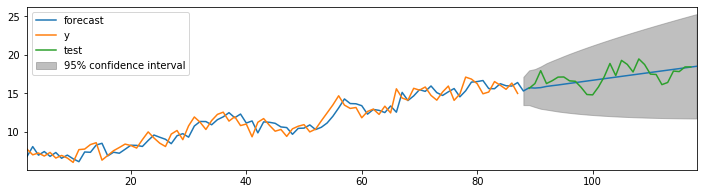

In [12]:
fc, se, conf = results.forecast(len(test), alpha=0.05) 
forecast = pd.Series(fc, index=test.index)
results.plot_predict(2, len(ts_log))
test.plot(label='test')
plt.legend()

In [13]:
print('Точность модели: {0:.2%}'.format(1-np.mean(np.abs(forecast - test)/np.abs(test))))

Точность модели: 94.66%


## Применение GARCH

In [14]:
from arch import arch_model

In [15]:
ts_log = np.diff(ts.iloc[:,1])

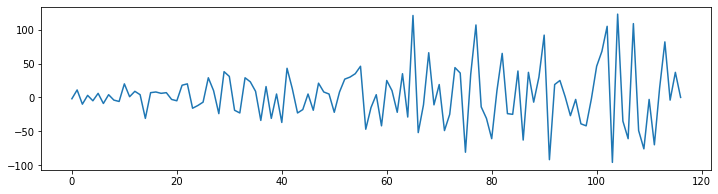

In [16]:
plt.plot(ts_log)

In [17]:
train = ts_log[:int(len(ts_log)*0.75)]
test = ts_log[int(len(ts_log)*0.75):]

In [18]:
model = arch_model(ts_log, vol='GARCH', p=10, q=10, o=0)#, dist='StudentsT')
model_fit = model.fit(disp='off', last_obs=len(train)-1)

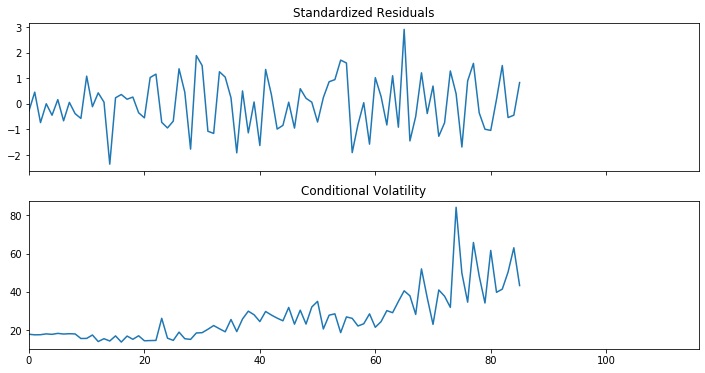

In [19]:
plt.rcParams['figure.figsize'] = (12,6)
model_fit.plot();